In [16]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

h5_path = '/home/jorvis/git/gEAR/www/datasets/c4f16a12-9e98-47be-4335-b8321282919e.h5ad'

adata = sc.read_h5ad(h5_path)

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [17]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 506 genes that are detected in less than 3 cells


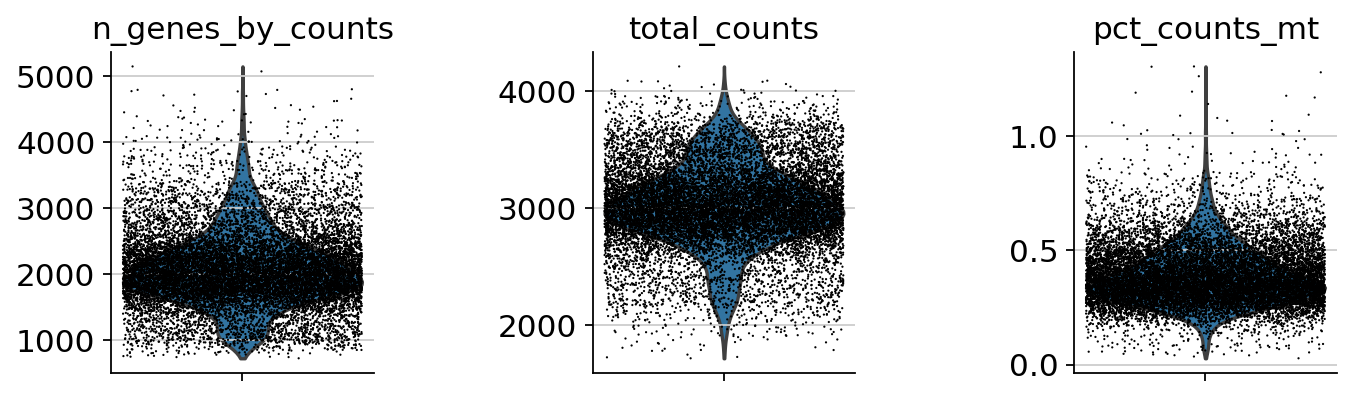

In [18]:
adata.var['mt'] = adata.var.gene_symbol.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

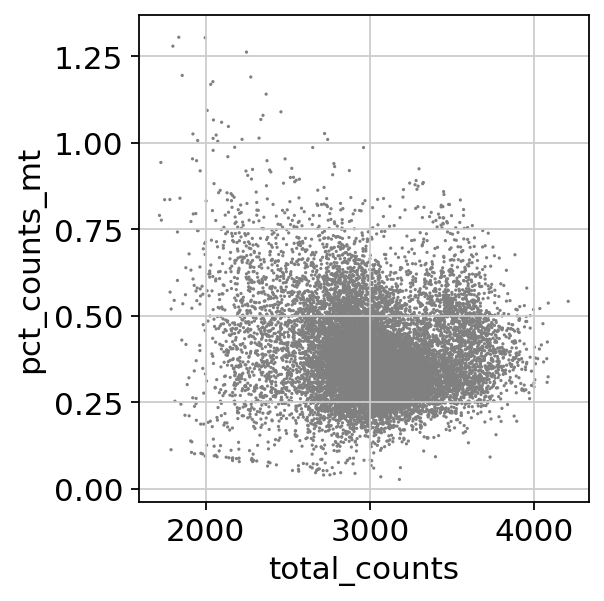

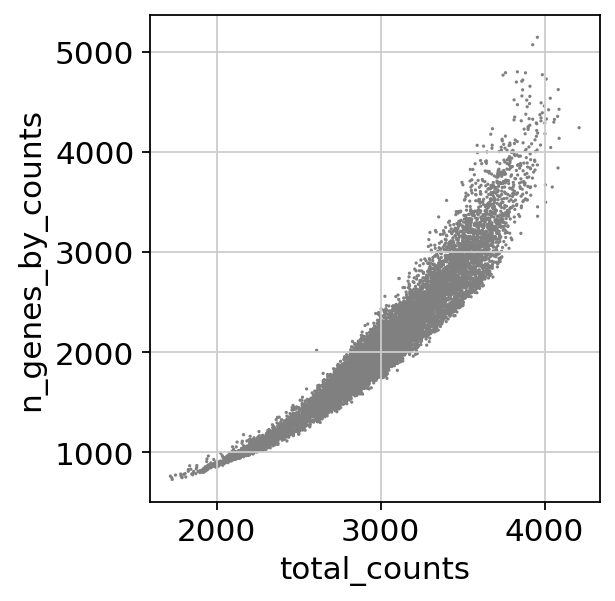

In [19]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [20]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [22]:
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.normalize_total(adata, target_sum=2000)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [25]:
sc.pp.highly_variable_genes(
            adata, flavor="seurat", n_top_genes=2000)

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


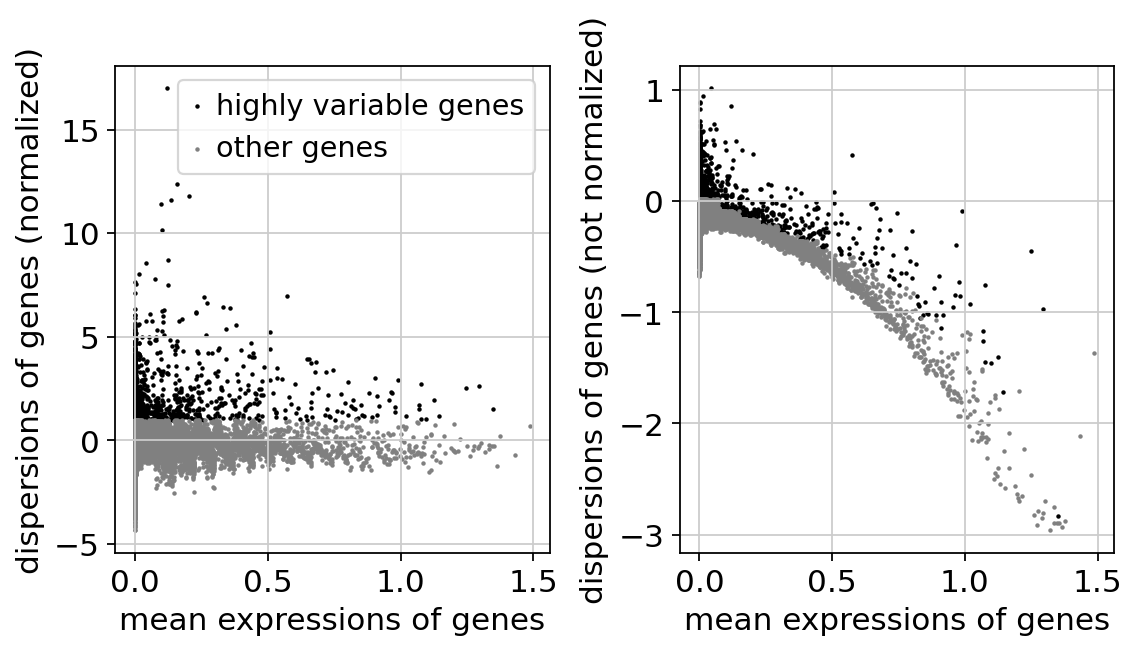

In [26]:
sc.pl.highly_variable_genes(adata)